# Part 2: Modeling and Insights

## Table of Contents:
- [Import Libraries](#Import-Libraries)
- [Data Preparation](#Data-Preparation)
- [Modeling - Preparation](#Modeling)
    - [Baseline ROC AUC](#Baseline-ROC-AUC)
    - [Modeling Dictionary](#Modeling-Dictionary)
    - [Function - Score](#Function:-Score-Printer)
    - [Function - Model](#Function:-Model)
- [Modeling - Base Models](#Modeling:-Preparation)
    - [Model 1: Logistic Regression](#Model-1:-Logistic-Regression)
    - [Model 2: K-Nearest Neighbors](#Model-2:-K-Nearest-Neighbors)
    - [Model 3: Decision Tree](#Model-3:-Decision-Tree)
    - [Model 4: Random Forest](#Model-4:-Random-Forest)
    - [Model 5: Support Vector Machine (Classifier)](#Model-5:-Support-Vector-Machine-(Classifier))
    - [Model 6: XGBoost (Classifier)](#Model-6:-XGBoost-(Classifier))
    - [Conclusion: Baseline Models](#Conclusion:-Baseline-Models)
- [Modeling - Hyperparameters Tuning](#Modeling:-Hyperparameter-Tuning)
    - [Model 7: Logistic Regression Hypertuned](#Model-7:-Logistic-Regression-Hypertuned)
    - [Model 8: Random Forest Hypertuned](#Model-8:-Random-Forest-Hypertuned)
    - [Model 9: Support Vector Machine (Classifier) Hypertuned]((#Model-9:-SVC-Hypertuned))
    - [Model 10: XGBoost (Classifier) Hypertuned](#Model-10:-XGBoost-Hypertuned)
    - [Model 11: XGBoost (Classifier) 2nd Hypertuned](#Model-11:-XGBoost-Hypertuned-2nd)
    - [Feature Importance](#Feature-Importance)
- [Conclusion & Recommendation](#Conclusion-and-Recommendation)
- [Kaggle](#Kaggle-Submission)


## Import Libraries

In [1]:
!pip install xgboost

In [2]:
# import essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid")

# handle date time
import datetime as dt

# model-related libraries for classifications
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
#from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.svm import SVC

from xgboost import XGBClassifier
import xgboost as xgb

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, plot_roc_curve

import warnings
warnings.filterwarnings('ignore')

## Data Preparation

### Load the Cleaned and Feature-Engineered Data

In [3]:
# Load data from our Part1: Data Cleaning
df_train = pd.read_csv('../assets/train_linear.csv')
y = 'WnvPresent'

In [4]:
# look at the % of data per classification 

df_train.WnvPresent.value_counts(normalize=True)

0    0.946077
1    0.053923
Name: WnvPresent, dtype: float64

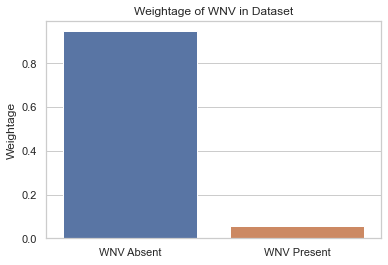

In [5]:
# barplot of the imbalance dataset
sns.barplot(x=['WNV Absent', 'WNV Present'], y = df_train.WnvPresent.value_counts(normalize=True))
plt.ylabel('Weightage');
plt.title('Weightage of WNV in Dataset');


#### Comment:
We will have to handle the imbalance dataset in our modeling

In [6]:
# look at the first 5 entries
df_train.head()

,Latitude,Longitude,wnv_species,WnvPresent,month,year,week,Tmax,Tmin,Tavg,...,Cool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Sunrise,Sunset,SnowFall
0,41.862292,-87.648860,1.0,0,5,2007,22,132.0,92.5,112.5,...,15.0,0.0,44.11,45.155,8.7,26.0,10.2,15660,69420,0.0
1,41.896282,-87.655232,1.0,0,5,2007,22,132.0,92.5,112.5,...,15.0,0.0,44.11,45.155,8.7,26.0,10.2,15660,69420,0.0
2,41.867108,-87.654224,3.0,0,5,2007,22,132.0,92.5,112.5,...,15.0,0.0,44.11,45.155,8.7,26.0,10.2,15660,69420,0.0
3,41.867108,-87.654224,1.0,0,5,2007,22,132.0,92.5,112.5,...,15.0,0.0,44.11,45.155,8.7,26.0,10.2,15660,69420,0.0
4,41.907645,-87.760886,1.0,0,5,2007,22,132.0,92.5,112.5,...,15.0,0.0,44.11,45.155,8.7,26.0,10.2,15660,69420,0.0


## Modeling - Preparation
Our models would be evaluated using (Receiver Operating Characteristics - Area Under Curve) ROC AUC, the ROC is the probability curve and AUC is the degree or measure of separability. It tells us how much the model is capable of distinguising between the classes (classifications). 
- The higher the AUC, the better the model is at predicting.
- The score ranges from 0 to 1.
- In the curve, the y-axis is the True Positive Rate (TPR) (*sometimes known as Recall or Sensitivity*)

$$ TPR = \frac{TP}{TP + FN} $$

- In the curve, the x-axis is the False Positive Rate (FPR)

$$ FPR = \frac{FP}{FP + TN} $$



### Baseline ROC AUC
Note that our baseline ROC AUC score would be **0.5**. This would be further explored when plot against the ROC AUC score for different models.

### Modeling Dictionary
This section stores the dictionary of all the models and scalers that would be used for the modeling, we will call their short forms during modeling process.

In [7]:
# Defining dictionary of pipeline transformers and classifiers

pipe_dict = {'ss' : ('ss', StandardScaler()),
             'lr' : ('lr', LogisticRegression()),
             'knn' : ('knn', KNeighborsClassifier()),
             'dt' : ('dt', DecisionTreeClassifier()),
             'rf' : ('rf', RandomForestClassifier()),
             'svc' : ('svc', SVC(probability=True)),
             'xgc' : ('xgc', XGBClassifier())
            }

pipe_dict_names = {'ss' : 'Standard Scaler',
                   'lr' : 'Logistic Regression',
                   'knn' : 'K-Nearest Neighbors',
                   'dt' : 'Decision Tree',
                   'rf' : 'Random Forest',
                   'svc' : 'Support Vector Machine Classifier',
                   'xgc' : 'XGBoost Classifier'
                  }

### Function: Score Printer
This function is created to be called within the modeling function to print the scores.

In [8]:
# function for score printer & best param to be called within the model function
def score_param_printer(model, X_train, X_test, y_train, y_test, model_base, model_summary_df):
    ''' Input the model, X_train, X_test, y_train, y_test, model_base (0: baseline, 1: non-baseline), model_summary_df
    print the best, train, test scores and best params, and other scores
    output the model_summary_df with scores '''
    
    print("\n======== All Scores ========")
    #calculate the scores for best, train, and test
    if model_base == 0:
        model_best_score = model.best_score_
        print(f"Best ROC AUC Score: {round(model_best_score, 4)}")

    else: # there is no hyper tuning
        model_best_score = 'No Hyper Tuning'
        print(f"Best ROC AUC Score: {model_best_score}")

    # Since the scoring metric = ROC AUC for models in GridSearchCV, 
    # then to get accuracy score, we can use the accuracy library from metrics.
    model_acc_score_train = accuracy_score(y_train, model.predict(X_train))
    model_acc_score_test = accuracy_score(y_test, model.predict(X_test))
    # print both the train and test accuracy scores
    print(f"Train Accuracy: {round(model_acc_score_train, 4)}")
    print(f"Test Accuracy: {round(model_acc_score_test, 4)}")

    #print(cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean())
    #model_train_score = model.score(X_train, y_train)
    #model_test_score = model.score(X_test, y_test)
    #print(f"Training Score: {round(model_train_score, 4)}")
    #print(f"Testing Score: {round(model_test_score, 4)}")
    
    if model_base == 0:
        print("\n======== Best Params =======")
        for param, value in model.best_params_.items():
            print(f"{param}: {value}")
    
    print('\n======= Performance ========')   
    # predict using the model
    preds = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    
    # Special NOTE: need to use the probability not the prediction
    model_roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    print(f'ROC AUC score: {round(model_roc_auc, 4)}')
    
    specificity = tn / (tn + fp)
    print(f'Specificity: {round(specificity, 4)}')
    
    # sensitivity = tp / (tp + fn)
    sensitivity = recall_score(y_test, preds)
    print(f'Sensitivity: {round(sensitivity, 4)}')
    
    # precision = tp / (tp + fp)
    precision = precision_score(y_test, preds)
    print(f'Precision: {round(precision, 4)}')
    
    # f1score = 2 * (precision*sensitivity) / (precision + sensitivity)
    f1score = f1_score(y_test, preds)
    print(f'F1 score: {round(f1score, 4)}')
    
    # Plot confusion matrix using sns heatmap
    cm = confusion_matrix(y_test, preds)
    cm_df = pd.DataFrame(cm,
                        index = ["WNV Absent", "WNV Present"],
                        columns = ["WNV Absent", "WNV Present"])

    plt.figure(figsize=(6,4)) #set the figure size
    sns.set(font_scale = 1.2) # set the font scale
    sns.heatmap(cm_df, annot=True, fmt='g', center=1, cmap='Spectral', linewidths=3, linecolor='black') #create heatmap
    plt.title(f"True vs Predicted WNV of {model_summary_df.Model[0]}") #plot title w name of model
    plt.ylabel("True Label") #plot y label
    plt.xlabel("Predicted Label"); #plot x label
    
    # Plot ROC Curve
    plot_roc_curve(model, X_test, y_test)
    plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
    plt.legend(['ROC Curve', 'Baseline'], loc='lower right')
    plt.title(f'ROC Curve of {model_summary_df.Model[0]}'); #give the title the name as model
    
    #record the score in the model_summary_df
    
    if model_base != 1: # not 1 means that the model_base has no hypertuning         
        # temp dict to store best param and conver them to a list to impute into a single cell in DF
        temp_dict = dict() 
        temp_dict['Best Param'] = model.best_params_
        model_summary_df['Best Param'] = [temp_dict['Best Param']]
        
    else: #model has no hyper tuning
        model_summary_df['Best Param'] = 'No Hyper Tuning'
    
    model_summary_df['Best ROC AUC Score'] = model_best_score
    model_summary_df['Train Acc Score'] = model_acc_score_train 
    model_summary_df['Test Acc Score'] = model_acc_score_test
    model_summary_df['ROC AUC Score'] = model_roc_auc

    
    return model_summary_df
    

### Function: Model
- This function will have the following input:
    - dataframe - The dataset including target variable
    - target_variable - The target variable, whether WMV is present.
    - model_name in short form - The short name of the model as defined in [Modeling Dictionary Section](#Modeling-Dictionary)
    - model_scaler in short form - The short name of the model scaler as defined in [Modeling Dictionary Section](#Modeling-Dictionary)
    - all_models_summary - The current model summary **dataframe**, putting this df into the function will update the all_models_summary.
    - param_dict - The parameters for hypertuning in **dictionary** form.
    - pipe_dict - The pipe dictionary as defined in [Modeling Dictionary Section](#Modeling-Dictionary)
    - pipe_dict_names - The names of the pipe as defined in [Modeling Dictionary Section](#Modeling-Dictionary)
    
    
**Predefined parameters:**
- **Train Test Split**
    - test_size = 0.33
    - random_state = 42
    - stratify by y
- **GridSearchCV**
    - cv = 5
    - scoring = 'roc_auc'
    - n_jobs = -1

In [9]:
def model_creation(dataframe, #(dataframe) dataset including target variable
                  target_variable, #(string) name of target variable
                  model_name, #(string) name of model (as defined in model dictionary)
                  model_scaler= "",  #(string) name of model scaler (as defined in model dictionary)
                  all_models_summary= [], #(dataframe) summary dataframe of all current models and their results
                  param_dict= {}, #(dict) hypertuning parameters for GridSearchCV
                  pipe_dict= pipe_dict, #(dict) dictionary of all models (and scalers)
                  pipe_dict_names= pipe_dict_names, #(dict) dictionary of all proper names of the models
                  test_size= 0.33, #(int) proportion of test dataset
                  cv= 5): #(int) cross validation 
    
    '''Input the dataframe, target variable, model_name, model_scaler, all_models_summary, param_dict for hypertuning, 
    pipe_dict, pipe_dict_names, test_size, cv
    Output the model and the updated summary of all the models, through the process, there will be prints of scores and best params'''
    
    # Initialize the X and y data
    X= dataframe.drop(columns=target_variable)
    y= dataframe[target_variable]
    
    # Initialize with the current model_summary_df, this is just for the current model
    model_summary_df = pd.DataFrame()
    
    # create dataframe for model_summary if there is no dataframe input
    if len(all_models_summary) == 0:
        all_models_summary = pd.DataFrame()    
    
    # using the dataset, perform train test split, having this inside ensures that 
    # it is a fair comparison between models (and no data leakage)
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size= test_size,
                                                        random_state= 42,
                                                        stratify= y)
    
    # Assign Model full name to Model column in dataframe
    model_summary_df['Model'] = [pipe_dict_names[model_name]]
    
    # Print Model for easy reference
    print("====== Model Summary =======")
    print(f"Model: {model_summary_df.Model[0]}")
    
    # Print Scaler for easy reference
    if len(model_scaler) == 0:  # meaning no scaler

        model_summary_df['Scaler'] = ['No Scaler']
        print("Scaler: No") # print no scaler

        model_pipe = Pipeline([
            (pipe_dict[model_name])
        ])
        
    else: # meaning there is scaler input

        model_summary_df['Scaler'] = [pipe_dict_names[model_scaler]]
        print(f"Scaler: {model_summary_df.Scaler[0]}")
                                                            
        model_pipe = Pipeline([
            (pipe_dict[model_scaler]),
            (pipe_dict[model_name])
        ])
    
    if param_dict != {}: #there is param for hypertuning
        print('Hyper Tunings: Yes') #print hyper tuning as yes
        model_base = 0 # this is generated as 0 for model_base when it is not baseline model
        
        gs_model = GridSearchCV(model_pipe,
                                param_grid= param_dict,
                                cv=cv,
                                scoring= 'roc_auc',
                                verbose=1,
                                n_jobs=-1)
        
        # model fitting
        model = gs_model.fit(X_train, y_train)
        
        # call function defined for scoring
        #score_param_printer(gs_model, X_train, X_test, y_train, y_test, model_base, model_summary_df)
        
    else: #there is no param for hypertuning, i.e. baseline model without hyper tuning
        print('Hyper Tunings: No') #print hyper tuning as no
        
        model_base = 1 #this is generated as 1 for model_base when it is baseline
        model = model_pipe.fit(X_train, y_train)
        

    #call function defined for scoring
    score_param_printer(model, X_train, X_test, y_train, y_test, model_base, model_summary_df)
    #print(model)

    # update the model summary    
    all_models_summary = pd.concat([all_models_summary, model_summary_df]) 
    all_models_summary.reset_index(drop=True, inplace=True) #reset the index
    
    return model, all_models_summary
        


## Modeling: Baseline Models
In this section, we will explore 6 models using their base parameters. This will help us to identify the top few models for hyper parameters tuning. 
- Logistic Regression
- KNN
- Decision Tree
- Random Forest
- SVC
- XGBoost

### Model 1: Logistic Regression 
Model without any hypertuning.

Logistic regression is a natural bridge to connect regression and classification.
- Logistic regression is the most common binary classification algorithm.
- Because it is a regression model, logistic regression will predict continuous values.
    - Logistic regression will predict continuous probabilities between 0 and 1.
    - In our case: What is the probability that WNV is present?
- However, logistic regression almost always operates as a classification model.
    - Logistic regression will use these continuous predictions to classify something as 0 or 1.
    - It is essentially a rounding of the probability found, where prob > 0.5 will be considered as 1 (present)

====== Model Summary =======
Model: Logistic Regression
Scaler: Standard Scaler
Hyper Tunings: No

======== All Scores ========
Best ROC AUC Score: No Hyper Tuning
Train Accuracy: 0.9461
Test Accuracy: 0.946

======= Performance ========
ROC AUC score: 0.8182
Specificity: 1.0
Sensitivity: 0.0
Precision: 0.0
F1 score: 0.0


,Model,Scaler,Best Param,Best ROC AUC Score,Train Acc Score,Test Acc Score,ROC AUC Score
0,Logistic Regression,Standard Scaler,No Hyper Tuning,No Hyper Tuning,0.946108,0.946014,0.818189


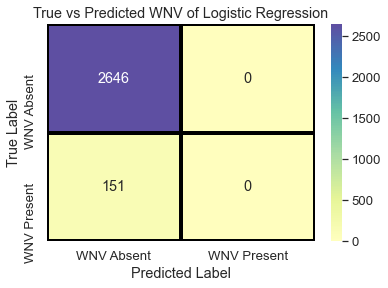

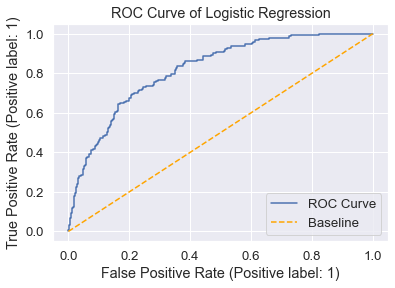

In [10]:
lr, models_summary_df = model_creation(dataframe= df_train, 
                                    target_variable= y, 
                                    model_name= 'lr',
                                    model_scaler= 'ss')

models_summary_df.tail(1)

### Model 2: K Nearest Neighbors
Model without any hypertuning.

There are alternatives in the case where we cannot assume a particular distribution for our data or choose not to. These methods are **nonparametric** When we make no assumptions about the distribution for our data, we call our data nonparametric. For nearly every parametric test, there is a nonparametric analog available. The KNN model is an example of a nonparametric model. We can see that there are no coefficients for the different predictors and our estimate is not represented by a formula of our predictor variables.

The pseudocode algorithm for kNN is as follows:



```
for unclassified_point in sample:
    for known_point in known_class_points:
        calculate distances (euclidean or other) between known_point and unclassified_point
    for k in range of specified_neighbors_number:
        find k_nearest_points in known_class_points to unclassified_point
    assign class to unclassified_point using "votes" from k_nearest_points
```

====== Model Summary =======
Model: K-Nearest Neighbors
Scaler: Standard Scaler
Hyper Tunings: No

======== All Scores ========
Best ROC AUC Score: No Hyper Tuning
Train Accuracy: 0.9489
Test Accuracy: 0.941

======= Performance ========
ROC AUC score: 0.7268
Specificity: 0.9902
Sensitivity: 0.0795
Precision: 0.3158
F1 score: 0.127


,Model,Scaler,Best Param,Best ROC AUC Score,Train Acc Score,Test Acc Score,ROC AUC Score
1,K-Nearest Neighbors,Standard Scaler,No Hyper Tuning,No Hyper Tuning,0.948926,0.941008,0.726772


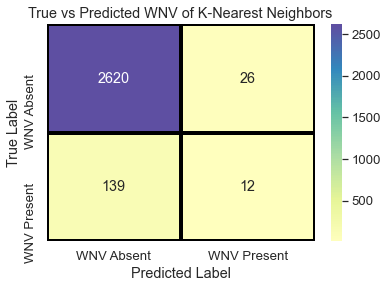

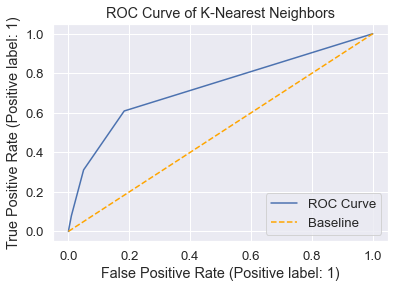

In [11]:
knn, models_summary_df = model_creation(dataframe= df_train, 
                                     target_variable= y, 
                                     model_name='knn',
                                     model_scaler = 'ss',
                                     all_models_summary= models_summary_df)

models_summary_df.tail(1)

### Model 3: Decision Tree
Model without any hypertuning.

Note that decision tree tends to overfit.

A decision tree:

- takes a dataset consisting of  𝑋  and  𝑌  data,
- finds rules based on our  𝑋  data that partitions (splits) our data into smaller datasets such that
- by the bottom of the tree, the values  𝑌  in each "leaf node" are as "pure" as possible.

====== Model Summary =======
Model: Decision Tree
Scaler: No
Hyper Tunings: No

======== All Scores ========
Best ROC AUC Score: No Hyper Tuning
Train Accuracy: 1.0
Test Accuracy: 0.9092

======= Performance ========
ROC AUC score: 0.6023
Specificity: 0.9463
Sensitivity: 0.2583
Precision: 0.2155
F1 score: 0.2349


,Model,Scaler,Best Param,Best ROC AUC Score,Train Acc Score,Test Acc Score,ROC AUC Score
2,Decision Tree,No Scaler,No Hyper Tuning,No Hyper Tuning,1.0,0.909188,0.602306


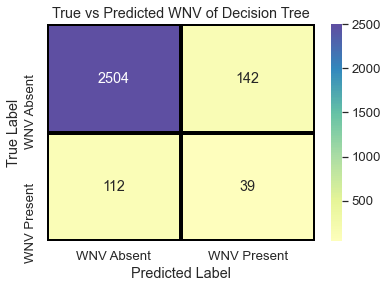

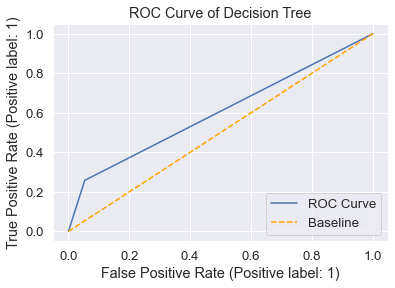

In [12]:
dt, models_summary_df = model_creation(dataframe= df_train, 
                                    target_variable= y, 
                                    model_name='dt',
                                    all_models_summary= models_summary_df)

models_summary_df.tail(1)

### Model 4: Random Forest
Model without any hypertuning.

Random forests differ from bagging decision trees in only one way: they use a modified tree learning algorithm that selects, at each split in the learning process, a **random subset of the features**. This process is sometimes called the *random subspace method*.

The reason for doing this is the correlation of the trees in an ordinary bootstrap sample: if one or a few features are very strong predictors for the response variable (target output), these features will be used in many/all of the bagged decision trees, causing them to become correlated. By selecting a random subset of features at each split, we counter this correlation between base trees, strengthening the overall model.

For a problem with $p$ features, it is typical to use:

- $\sqrt{p}$ (rounded down) features in each split for a classification problem.
- $p/3$ (rounded down) with a minimum node size of 5 as the default for a regression problem.

====== Model Summary =======
Model: Random Forest
Scaler: No
Hyper Tunings: No

======== All Scores ========
Best ROC AUC Score: No Hyper Tuning
Train Accuracy: 0.9998
Test Accuracy: 0.9417

======= Performance ========
ROC AUC score: 0.8156
Specificity: 0.9887
Sensitivity: 0.1192
Precision: 0.375
F1 score: 0.1809


,Model,Scaler,Best Param,Best ROC AUC Score,Train Acc Score,Test Acc Score,ROC AUC Score
3,Random Forest,No Scaler,No Hyper Tuning,No Hyper Tuning,0.999824,0.941723,0.815622


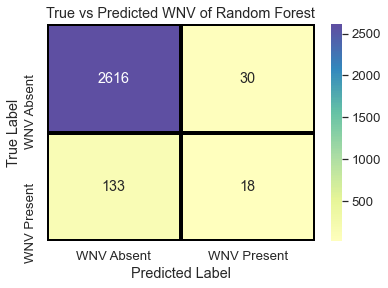

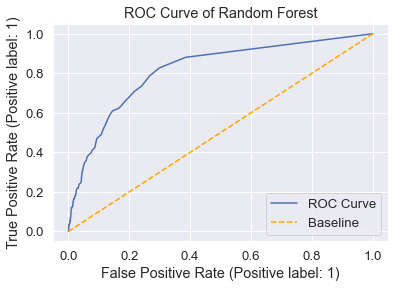

In [13]:
rf, models_summary_df = model_creation(dataframe= df_train, 
                                    target_variable= y, 
                                    model_name='rf',
                                    all_models_summary= models_summary_df)

models_summary_df.tail(1)

### Model 5: Support Vector Machine (Classifier)
Model without any hypertuning.

Support vector machines (SVMs) are classification models*, that is, they predict categorical variables. They belong to a wider class of models called discriminant models. 

#### Pros
- Exceptional perfomance (historically widely used)
- Effective in high-dimensional data
- Can work with non-linear boundaries
- Fast to compute with most datasets (kernel trick)

#### Cons
- Black box method
- Can be slow on large (tall) datasets


====== Model Summary =======
Model: Support Vector Machine Classifier
Scaler: Standard Scaler
Hyper Tunings: No

======== All Scores ========
Best ROC AUC Score: No Hyper Tuning
Train Accuracy: 0.9461
Test Accuracy: 0.946

======= Performance ========
ROC AUC score: 0.8052
Specificity: 1.0
Sensitivity: 0.0
Precision: 0.0
F1 score: 0.0


,Model,Scaler,Best Param,Best ROC AUC Score,Train Acc Score,Test Acc Score,ROC AUC Score
4,Support Vector Machine Classifier,Standard Scaler,No Hyper Tuning,No Hyper Tuning,0.946108,0.946014,0.805161


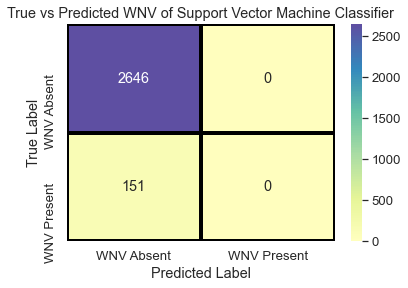

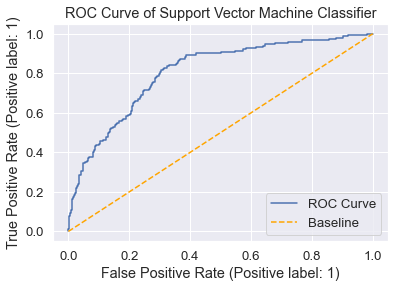

In [14]:
svc, models_summary_df = model_creation(dataframe= df_train, 
                                     target_variable= y, 
                                     model_name= 'svc',
                                     model_scaler= 'ss',
                                     all_models_summary= models_summary_df)

models_summary_df.tail(1)

### Model 6: XGBoost (Classifier)
Model without any hypertuning.

XGboost is the most widely used algorithm in machine learning, whether the problem is a classification or a regression problem. It is known for its good performance as compared to all other machine learning algorithms. Even when it comes to machine learning competitions and hackathon, XGBoost is one of the excellent algorithms that is picked initially for structured data. It has proved its determination in terms of speed and performance. *([Source](https://www.analyticssteps.com/blogs/introduction-xgboost-algorithm-classification-and-regression))*

====== Model Summary =======
Model: XGBoost Classifier
Scaler: No
Hyper Tunings: No
[01:06:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

======== All Scores ========
Best ROC AUC Score: No Hyper Tuning
Train Accuracy: 0.9857
Test Accuracy: 0.9414

======= Performance ========
ROC AUC score: 0.8618
Specificity: 0.9837
Sensitivity: 0.1987
Precision: 0.411
F1 score: 0.2679


,Model,Scaler,Best Param,Best ROC AUC Score,Train Acc Score,Test Acc Score,ROC AUC Score
5,XGBoost Classifier,No Scaler,No Hyper Tuning,No Hyper Tuning,0.985734,0.941366,0.861841


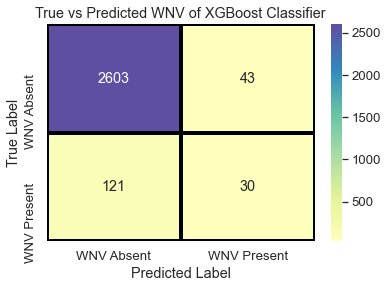

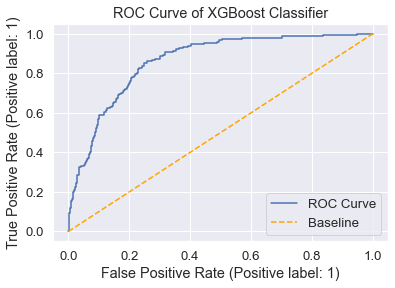

In [15]:
xgc, models_summary_df = model_creation(dataframe= df_train, 
                                     target_variable= y, 
                                     model_name= 'xgc',
                                     all_models_summary= models_summary_df)

models_summary_df.tail(1)

### Conclusion: Baseline Models
In this section, we will look at all the baseline models and their **ROC AUC Score** to decide on which are the models to further dive deeper.

All the models here outperformed the baseline ROC AUC score of 0.5.

As expected, *XGBoost* performed the best. In addition, 3 other models also performed relatively well at about 80% ROC AUC Score.
- Logistic Regression
- Random Forest
- SVC


In [16]:
models_summary_df.sort_values(by='ROC AUC Score', ascending=False)

,Model,Scaler,Best Param,Best ROC AUC Score,Train Acc Score,Test Acc Score,ROC AUC Score
5,XGBoost Classifier,No Scaler,No Hyper Tuning,No Hyper Tuning,0.985734,0.941366,0.861841
0,Logistic Regression,Standard Scaler,No Hyper Tuning,No Hyper Tuning,0.946108,0.946014,0.818189
3,Random Forest,No Scaler,No Hyper Tuning,No Hyper Tuning,0.999824,0.941723,0.815622
4,Support Vector Machine Classifier,Standard Scaler,No Hyper Tuning,No Hyper Tuning,0.946108,0.946014,0.805161
1,K-Nearest Neighbors,Standard Scaler,No Hyper Tuning,No Hyper Tuning,0.948926,0.941008,0.726772
2,Decision Tree,No Scaler,No Hyper Tuning,No Hyper Tuning,1.000000,0.909188,0.602306


## Modeling: Hyperparameter Tuning
In this section, we will dive deeper by hyperparameter tuning the identified 4 models. In particular, we will need to handle the imbalance in the classifications. 
- Logistic Regression
- Random Forest
- SVC
- XGBoost

As these models are performing generally well in terms of ROC AUC Score (more than 80%), we are also interested to look at reducing the False Negative (FN: Type II Error), i.e. predicting that WNV is absent, however, it actually is present. As the mission is ultimately to help the people, we do not wish to potentially missed the chances of "believing it is true". However, we would still need to strike a balance on this aspect of cost versus benefit.

To reduce potential cost, looking at False Positive (FP: Type I error) is important as well, i.e. predicting that WNV is present, but it is actually absent. This will reduce our need for the spray/efforts to tackle the WNV, and hence reducing cost incurred. 

### Model 7: Logistic Regression Hypertuned
The following hyperparameters are explored:

- `penalty`
    - Used to specify the norm used in the penalization. The ‘newton-cg’, ‘sag’ and ‘lbfgs’ solvers support only l2 penalties. ‘elasticnet’ is only supported by the ‘saga’ solver. If ‘none’ (not supported by the liblinear solver), no regularization is applied.
- `solver`
    - Algorithm to use in the optimization problem.
- `C`
    - Iverse of regularization strength. Like in support vector machines, smaller values specify stronger regularization.
- `class_weight`
    - The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)).
    
[Source](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [17]:
# define hyperpara for model to fine tune using GridSearchCV
lr_params = {'lr__penalty' : ['l1', 'l2'],
            'lr__solver' : ['liblinear'],
            'lr__C' : np.logspace(-5, 0, 5),
            'lr__class_weight' : ['balanced'],
            'lr__random_state': [42]}

====== Model Summary =======
Model: Logistic Regression
Scaler: Standard Scaler
Hyper Tunings: Yes
Fitting 5 folds for each of 10 candidates, totalling 50 fits

======== All Scores ========
Best ROC AUC Score: 0.7989
Train Accuracy: 0.6499
Test Accuracy: 0.6593

======== Best Params =======
lr__C: 1.0
lr__class_weight: balanced
lr__penalty: l1
lr__random_state: 42
lr__solver: liblinear

======= Performance ========
ROC AUC score: 0.8211
Specificity: 0.6485
Sensitivity: 0.8477
Precision: 0.121
F1 score: 0.2117


,Model,Scaler,Best Param,Best ROC AUC Score,Train Acc Score,Test Acc Score,ROC AUC Score
6,Logistic Regression,Standard Scaler,"{'lr__C': 1.0, 'lr__class_weight': 'balanced',...",0.798928,0.649877,0.659278,0.821114


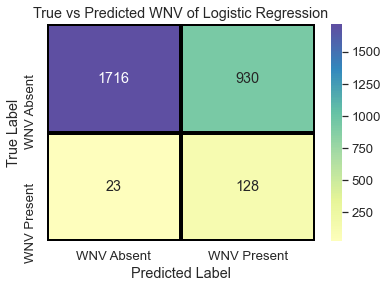

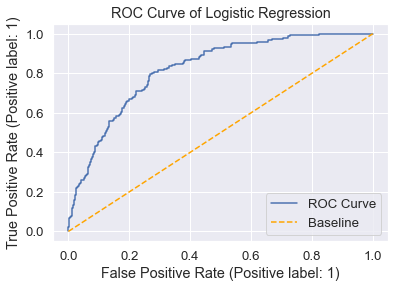

In [18]:
gs_lr, models_summary_df = model_creation(dataframe= df_train, 
                                     target_variable= y, 
                                     model_scaler='ss',
                                     model_name= 'lr',
                                     all_models_summary= models_summary_df,
                                     param_dict = lr_params)
models_summary_df.tail(1)

### Model 8: Random Forest Hypertuned
The following hyperparameters are explored:

- `n_estimators`
    - The number of trees in the forest.
- `max_depth`
    - The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
- `min_samples_leaf`
    - The minimum number of samples required to be at a leaf node
- `class_weight`
    - The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))   
- `max_features`
    - The number of features to consider when looking for the best split.
    
[Source](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [19]:
# define random forst params
rf_params = {'rf__n_estimators': [50, 100, 150],
            'rf__max_depth': [5, 15, 25],
            'rf__min_samples_leaf': [5, 10, 15],
            'rf__class_weight' : ['balanced'],
            'rf__max_features':['auto','log2', 1/3],
            'rf__random_state': [42]}

====== Model Summary =======
Model: Random Forest
Scaler: No
Hyper Tunings: Yes
Fitting 5 folds for each of 81 candidates, totalling 405 fits

======== All Scores ========
Best ROC AUC Score: 0.8375
Train Accuracy: 0.8445
Test Accuracy: 0.8245

======== Best Params =======
rf__class_weight: balanced
rf__max_depth: 15
rf__max_features: 0.3333333333333333
rf__min_samples_leaf: 15
rf__n_estimators: 150
rf__random_state: 42

======= Performance ========
ROC AUC score: 0.8633
Specificity: 0.8314
Sensitivity: 0.702
Precision: 0.192
F1 score: 0.3016


,Model,Scaler,Best Param,Best ROC AUC Score,Train Acc Score,Test Acc Score,ROC AUC Score
7,Random Forest,No Scaler,"{'rf__class_weight': 'balanced', 'rf__max_dept...",0.83754,0.844487,0.824455,0.86329


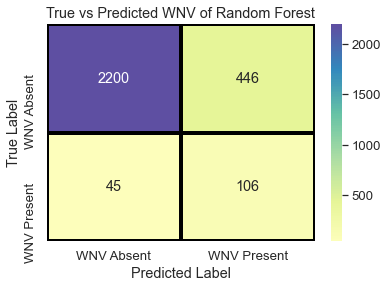

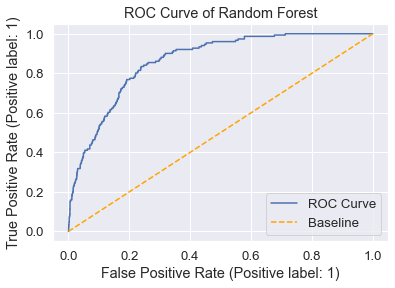

In [20]:
gs_rf, models_summary_df = model_creation(dataframe= df_train, 
                                       target_variable= y, 
                                       model_name='rf',
                                       all_models_summary= models_summary_df,
                                       param_dict=rf_params)

models_summary_df.tail(1)

### Model 9: SVC Hypertuned
The following hyperparameters are explored:

- `C`
    - Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty.
- `kernel`
    - Specifies the kernel type to be used in the algorithm
- `class_weight`
    - The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))
    
[Source](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

In [21]:
# To be explored for SVC

svc_params = {
    'svc__C': np.linspace(0.0001, 1, 50),
    'svc__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'svc__class_weight':['balanced'],
    'svc__random_state': [42]}
    

====== Model Summary =======
Model: Support Vector Machine Classifier
Scaler: Standard Scaler
Hyper Tunings: Yes
Fitting 5 folds for each of 200 candidates, totalling 1000 fits

======== All Scores ========
Best ROC AUC Score: 0.8328
Train Accuracy: 0.727
Test Accuracy: 0.7333

======== Best Params =======
svc__C: 0.897969387755102
svc__class_weight: balanced
svc__kernel: rbf
svc__random_state: 42

======= Performance ========
ROC AUC score: 0.8551
Specificity: 0.726
Sensitivity: 0.8609
Precision: 0.152
F1 score: 0.2584
Wall time: 1h 4min 59s


,Model,Scaler,Best Param,Best ROC AUC Score,Train Acc Score,Test Acc Score,ROC AUC Score
8,Support Vector Machine Classifier,Standard Scaler,"{'svc__C': 0.897969387755102, 'svc__class_weig...",0.832828,0.727017,0.733286,0.855118


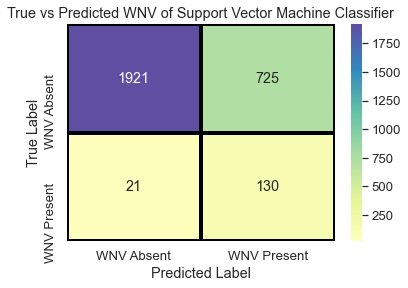

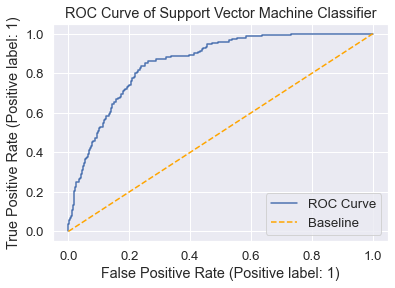

In [22]:
%%time
gs_svc, models_summary_df = model_creation(dataframe= df_train, 
                                     target_variable= y, 
                                     model_name= 'svc',
                                     model_scaler='ss',
                                     all_models_summary= models_summary_df,
                                     param_dict = svc_params,
                                     cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42))
models_summary_df.tail(1)

### Model 10: XGBoost Hypertuned
The following hyperparameters are explored:

- `eta`
    - Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.
    - This is the learning rate
- `max_depth`
    - Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit
- `min_child_weight`
    - Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning
- `gamma`
    - Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.
- `colsample_bytree`
    - is the subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.

In [23]:
xgc_params = {
    'xgc__eval_metric' : ['auc'],   
    "xgc__eta"    : [0.10,  0.20, 0.30 ] ,
    "xgc__max_depth"        : [ 4, 5, 6, 7, 8],
    "xgc__min_child_weight" : [ 3, 5, 7 ],
    "xgc__gamma"            : [ 0.0, 0.2, 0.4 ],
    "xgc__colsample_bytree" : [ 0.3, 0.5 , 0.7 ],
    'xgc__random_state': [42]}

====== Model Summary =======
Model: XGBoost Classifier
Scaler: No
Hyper Tunings: Yes
Fitting 5 folds for each of 405 candidates, totalling 2025 fits

======== All Scores ========
Best ROC AUC Score: 0.8455
Train Accuracy: 0.9535
Test Accuracy: 0.9471

======== Best Params =======
xgc__colsample_bytree: 0.3
xgc__eta: 0.1
xgc__eval_metric: auc
xgc__gamma: 0.4
xgc__max_depth: 4
xgc__min_child_weight: 3
xgc__random_state: 42

======= Performance ========
ROC AUC score: 0.8642
Specificity: 0.994
Sensitivity: 0.1258
Precision: 0.5429
F1 score: 0.2043
Wall time: 7min 37s


,Model,Scaler,Best Param,Best ROC AUC Score,Train Acc Score,Test Acc Score,ROC AUC Score
9,XGBoost Classifier,No Scaler,"{'xgc__colsample_bytree': 0.3, 'xgc__eta': 0.1...",0.845452,0.953505,0.947086,0.864223


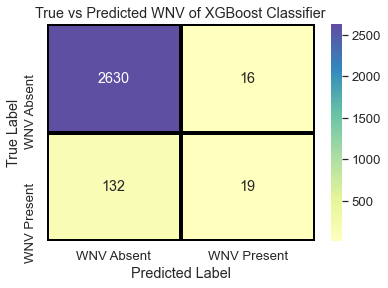

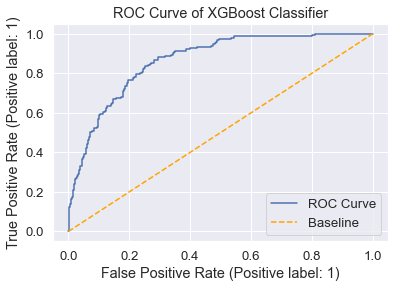

In [24]:
%%time
gs_xgc, models_summary_df = model_creation(dataframe= df_train, 
                                         target_variable= y, 
                                         model_name= 'xgc',
                                         all_models_summary= models_summary_df,
                                         param_dict = xgc_params)
models_summary_df.tail(1)

### Model 11: XGBoost Hypertuned 2nd

The following hyperparameters are explored:

- `eta`
    - Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.
    - This is the learning rate
- `max_depth`
    - Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit
- `min_child_weight`
    - Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning
- `gamma`
    - Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.
- `colsample_bytree`
    - is the subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.
- `scale_pos_weight`
    - Control the balance of positive and negative weights, useful for unbalanced classes. A typical value to consider: sum(negative instances) / sum(positive instances)
- `objective`
    - When used with binary classification, the objective should be binary:logistic or similar functions that work on probability

In [25]:
# adjust the class weight in xgboost by a ratio of negative_class vs positive class.
xgc_scaling = round(df_train.WnvPresent.value_counts()[0]/df_train.WnvPresent.value_counts()[1],1)
xgc_scaling_sqrt = round(xgc_scaling**(0.5),1)
print(f"ratio between WNV Absent and WNV Present: {xgc_scaling}")
print(f"sqrt of the ratio (conservative approach): {xgc_scaling_sqrt}")

ratio between WNV Absent and WNV Present: 17.5
sqrt of the ratio (conservative approach): 4.2


In [26]:
xgc_params2 = {
    'xgc__eval_metric' : ['auc'],   
    "xgc__eta"    : [0.10,  0.20, 0.30 ] ,
    "xgc__max_depth"        : [ 4, 5, 6 ],
    "xgc__min_child_weight" : [ 3, 5, 7 ],
    "xgc__gamma"            : [ 0.0, 0.2, 0.4 ],
    "xgc__colsample_bytree" : [ 0.3, 0.5 , 0.7 ],
    'xgc__scale_pos_weight' : [xgc_scaling, xgc_scaling_sqrt], #tuned based on class imbalanced of 17 times, and sqrt of that to be more consevative
    'xgc__seed' : [42],
    'xgc__objective' : ['binary:logistic', None]
}

====== Model Summary =======
Model: XGBoost Classifier
Scaler: No
Hyper Tunings: Yes
Fitting 5 folds for each of 972 candidates, totalling 4860 fits

======== All Scores ========
Best ROC AUC Score: 0.8411
Train Accuracy: 0.9435
Test Accuracy: 0.9167

======== Best Params =======
xgc__colsample_bytree: 0.3
xgc__eta: 0.1
xgc__eval_metric: auc
xgc__gamma: 0.4
xgc__max_depth: 4
xgc__min_child_weight: 3
xgc__objective: binary:logistic
xgc__scale_pos_weight: 4.2
xgc__seed: 42

======= Performance ========
ROC AUC score: 0.8655
Specificity: 0.946
Sensitivity: 0.404
Precision: 0.299
F1 score: 0.3437
Wall time: 18min 33s


,Model,Scaler,Best Param,Best ROC AUC Score,Train Acc Score,Test Acc Score,ROC AUC Score
10,XGBoost Classifier,No Scaler,"{'xgc__colsample_bytree': 0.3, 'xgc__eta': 0.1...",0.841096,0.943466,0.916696,0.865457


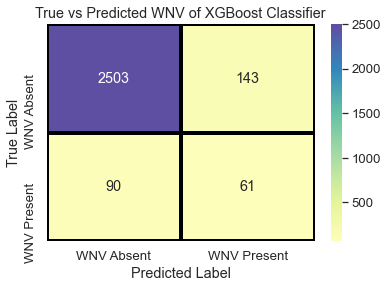

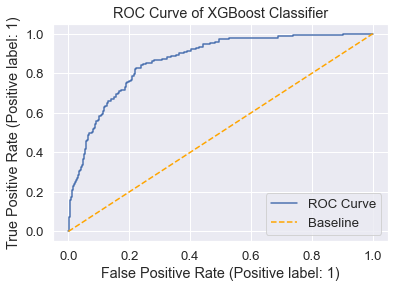

In [27]:
%%time
gs_xgc2, models_summary_df = model_creation(dataframe= df_train, 
                                         target_variable= y, 
                                         model_name= 'xgc',
                                         all_models_summary= models_summary_df,
                                         param_dict = xgc_params2)
models_summary_df.tail(1)

In [28]:
pd.set_option('display.max_colwidth', None)
models_summary_df.sort_values(by='ROC AUC Score',ascending=False)

,Model,Scaler,Best Param,Best ROC AUC Score,Train Acc Score,Test Acc Score,ROC AUC Score
10,XGBoost Classifier,No Scaler,"{'xgc__colsample_bytree': 0.3, 'xgc__eta': 0.1, 'xgc__eval_metric': 'auc', 'xgc__gamma': 0.4, 'xgc__max_depth': 4, 'xgc__min_child_weight': 3, 'xgc__objective': 'binary:logistic', 'xgc__scale_pos_weight': 4.2, 'xgc__seed': 42}",0.841096,0.943466,0.916696,0.865457
9,XGBoost Classifier,No Scaler,"{'xgc__colsample_bytree': 0.3, 'xgc__eta': 0.1, 'xgc__eval_metric': 'auc', 'xgc__gamma': 0.4, 'xgc__max_depth': 4, 'xgc__min_child_weight': 3, 'xgc__random_state': 42}",0.845452,0.953505,0.947086,0.864223
7,Random Forest,No Scaler,"{'rf__class_weight': 'balanced', 'rf__max_depth': 15, 'rf__max_features': 0.3333333333333333, 'rf__min_samples_leaf': 15, 'rf__n_estimators': 150, 'rf__random_state': 42}",0.83754,0.844487,0.824455,0.863290
5,XGBoost Classifier,No Scaler,No Hyper Tuning,No Hyper Tuning,0.985734,0.941366,0.861841
8,Support Vector Machine Classifier,Standard Scaler,"{'svc__C': 0.897969387755102, 'svc__class_weight': 'balanced', 'svc__kernel': 'rbf', 'svc__random_state': 42}",0.832828,0.727017,0.733286,0.855118
6,Logistic Regression,Standard Scaler,"{'lr__C': 1.0, 'lr__class_weight': 'balanced', 'lr__penalty': 'l1', 'lr__random_state': 42, 'lr__solver': 'liblinear'}",0.798928,0.649877,0.659278,0.821114
0,Logistic Regression,Standard Scaler,No Hyper Tuning,No Hyper Tuning,0.946108,0.946014,0.818189
3,Random Forest,No Scaler,No Hyper Tuning,No Hyper Tuning,0.999824,0.941723,0.815622
4,Support Vector Machine Classifier,Standard Scaler,No Hyper Tuning,No Hyper Tuning,0.946108,0.946014,0.805161
1,K-Nearest Neighbors,Standard Scaler,No Hyper Tuning,No Hyper Tuning,0.948926,0.941008,0.726772


### Feature Importance
In this section, we will look at the top 20 features of the selected model. From here, we understand that some of the following features have positive impact on the model prediction based on ROC AUC Score. 
- `Sunset & Sunrise` - This is inline with our research on Swarming Behaviour vs the time of the day. *([Source](https://en.wikipedia.org/wiki/Swarm_behaviour))*
- `PrecipTotal` - Average total precipitation between 2 stations
- `year, month` - Time of the year or month
- `Tavg` - Average temperature of the day between between 2 stations
- `wnv_species` - Species of wnv carrying mosquitoes being mapped with ('CULEX PIPIENS/RESTUANS': 3, 'CULEX PIPIENS': 2, 'CULEX RESTUANS': 1 and 0 for everything else)

In [29]:
X_train = df_train.drop(columns = y) # get the X train data
# get the coefficients of the gs_xgc model from the best estimator using feature importance
coef = gs_xgc2.best_estimator_.steps[0][1].feature_importances_

# put it into a data frame, and get the top 20 in descending order
feat_imp = pd.DataFrame({'features':X_train.columns,
                        'coef':coef,
                        'abs_coef':np.abs(coef)}).sort_values(by = 'abs_coef', ascending=False).head(20)

feat_imp

,features,coef,abs_coef
20,Sunset,0.110241,0.110241
13,PrecipTotal,0.097073,0.097073
4,year,0.085653,0.085653
19,Sunrise,0.081829,0.081829
8,Tavg,0.057165,0.057165
3,month,0.056626,0.056626
2,wnv_species,0.050066,0.050066
10,WetBulb,0.044690,0.044690
16,ResultSpeed,0.044484,0.044484
1,Longitude,0.043670,0.043670


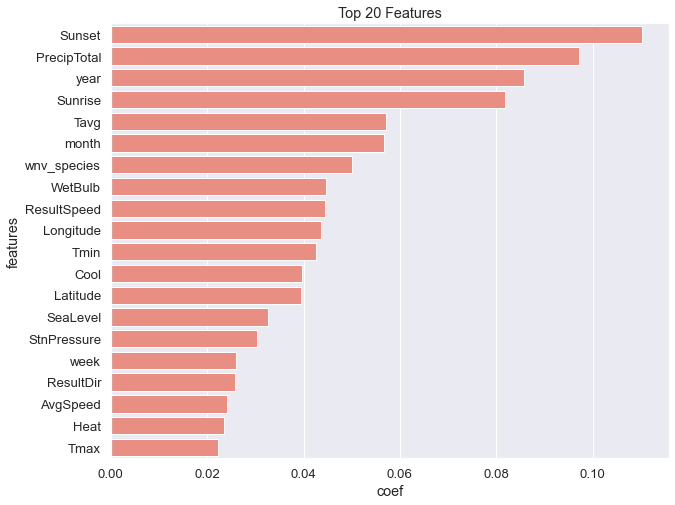

In [30]:
#plot the feature importance by their absolute value
plt.figure(figsize = (10, 8))
sns.barplot(x = feat_imp.coef, y =feat_imp.features, color = 'salmon')
plt.title("Top 20 Features");

## Conclusion and Recommendation

In [32]:
#get the top 5 models
models_summary_df.sort_values(by='ROC AUC Score',ascending=False).head(5)

,Model,Scaler,Best Param,Best ROC AUC Score,Train Acc Score,Test Acc Score,ROC AUC Score
10,XGBoost Classifier,No Scaler,"{'xgc__colsample_bytree': 0.3, 'xgc__eta': 0.1, 'xgc__eval_metric': 'auc', 'xgc__gamma': 0.4, 'xgc__max_depth': 4, 'xgc__min_child_weight': 3, 'xgc__objective': 'binary:logistic', 'xgc__scale_pos_weight': 4.2, 'xgc__seed': 42}",0.841096,0.943466,0.916696,0.865457
9,XGBoost Classifier,No Scaler,"{'xgc__colsample_bytree': 0.3, 'xgc__eta': 0.1, 'xgc__eval_metric': 'auc', 'xgc__gamma': 0.4, 'xgc__max_depth': 4, 'xgc__min_child_weight': 3, 'xgc__random_state': 42}",0.845452,0.953505,0.947086,0.864223
7,Random Forest,No Scaler,"{'rf__class_weight': 'balanced', 'rf__max_depth': 15, 'rf__max_features': 0.3333333333333333, 'rf__min_samples_leaf': 15, 'rf__n_estimators': 150, 'rf__random_state': 42}",0.83754,0.844487,0.824455,0.863290
5,XGBoost Classifier,No Scaler,No Hyper Tuning,No Hyper Tuning,0.985734,0.941366,0.861841
8,Support Vector Machine Classifier,Standard Scaler,"{'svc__C': 0.897969387755102, 'svc__class_weight': 'balanced', 'svc__kernel': 'rbf', 'svc__random_state': 42}",0.832828,0.727017,0.733286,0.855118


### Conclusion
Clearly, **XGBoost 2nd hypertuned** is the best model based on the **ROC AUC Score of 0.865**. In addition, as part of our problem statement, besides using ROC AUC Score for measuring the model prediction, we have to look at the **FN (Type II error) and FP (Type I Error)**. 

Though both XGBoost and Random Forest have similar ROC AUC Score (~86%), the FP of Random Forest is significantly higher as compared to XGBoost, this might have more potential cost incurred. 

- XGBoost
    - FN: 90 
    - FP: 143
    - Specificity: 0.946 (very low FP as compared to TN)
    - Sensitivity: 0.404 (high FN as compared to TP)
- Random Forest
    - FN: 45
    - FP: 446
    - Specificity: 0.8314 (low FP as compared to TN)
    - Sensitivity: 0.702 (rather low FN as compared to TP)
    
Below is a further breakdown on how FN and FP are important. Based on the 2 models:

`Assumption`: Based on model prediction, we assume that, when **WNV is predicted as present, we will spray pesticide**.

- `Type I Error (FP)`: Predicted WNV present, but actually there is no WNV present.
    - When FP is high, we might "overspray" the pesticides, which would have higher cost incurred.
    - Cost for spray operations. (estimated cost ~3,000/km2)
    - One way to look at FP is by looking at the Specificity (tn(tn + fp)) of the model where having a high Specificity, will mean that FP is rather low. 
   
- `Type II Error (FN)`: Predicted WNV absent, but actually there is WNV present. 
    - When FN is high, we might have compromised the safety of the people in Chicago as there is WNV present.
    - Cost incurred by the people, their family, the government, etc. (estimated cost ~2,700/case)
    - One way to look at FN is by looking at the Sensitivity (tp(tp + fn)) of the model where having a high Sensitivity, will mean that FN is rather low. 
    
Hence, keeping a balance between FP and FN is also an important factor in the social aspect.

### Recommendation: Cost Benefit Analysis

*Note that this is a summarized version, more could be found in README*

A cost benefit analysis would help in reducing some of the potential cost incurred from "overspraying" and "underspraying".

One recommendation we would suggest is to have spraying efforts could be concentrated at the beginning of July or latest August, instead of September. Assumming budget contrainst as the reason why spraying efforts had only been done in one location, what we would also recommend to make the spraying process more cost effective, is by having spraying efforts to be done in the region where the highest concentration of WNV had occured as well as the highest number of mosquito counts.

**Example: Case of 2011**

There is a region that covers an area of 5.42 km2. Spraying this area alone would only cost 16,323 dollars, and would have a higher likelihood to prevent the occurence of WNNF or WNND.
If spraying just this area could hypothetically reduce the number of people infected by 20%, and statistically, 16 people may develop WNF symptoms and 0 people develop WNND symptoms, the total cost to spray and in productivity loss would be 59,651 dollars. This would save the city, 81,603 dollars.

However, as the current datasets do not substantially point to a significant impact from spraying, more evidence (from a better designed spraying regime) are needed for a more concrete recommendation. For example, spraying efforts could be concentrated at the beginning of August so that there would be enough time to observe if mosquito numbers decline, in the relative absence of other confounding factors (such as temperature).

Nonetheless, the recommendations that we can offer is where and when spraying efforts could be done.
Other areas to study would include, the relationship between spray effectiveness and other factors such as wind direction, elevation or landscape. Or study the use of other methods such as larvicide.

## Kaggle Submission 
In this section, we predict the WnvPresent based on `predict.proba` on the test set. 

### Load Test Dataset

In [33]:
df_test = pd.read_csv("../assets/test_linear.csv")
df_test.head()

,Id,Latitude,Longitude,wnv_species,month,year,week,Tmax,Tmin,Tavg,...,Cool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Sunrise,Sunset,SnowFall
0,1,41.95469,-87.800991,3.0,6,2008,24,129.0,94.0,112.0,...,14.5,0.0,43.95,44.975,13.6,27.0,15.2,15360,69960,0.0
1,2,41.95469,-87.800991,1.0,6,2008,24,129.0,94.0,112.0,...,14.5,0.0,43.95,44.975,13.6,27.0,15.2,15360,69960,0.0
2,3,41.95469,-87.800991,2.0,6,2008,24,129.0,94.0,112.0,...,14.5,0.0,43.95,44.975,13.6,27.0,15.2,15360,69960,0.0
3,4,41.95469,-87.800991,0.0,6,2008,24,129.0,94.0,112.0,...,14.5,0.0,43.95,44.975,13.6,27.0,15.2,15360,69960,0.0
4,5,41.95469,-87.800991,0.0,6,2008,24,129.0,94.0,112.0,...,14.5,0.0,43.95,44.975,13.6,27.0,15.2,15360,69960,0.0


### Function: Model Prediction

In [34]:
def model_prediction(train_df, test_df, target_variable, model, drop_Id_col_name=''):
    '''Input training set, testing set, target variable, model selected and ID col to drop,
    Output the whole testing set with predicted value'''
    
    # generalized model, for kaggle submission, to drop ID column 
    if len(drop_Id_col_name) > 0:
        X_test = test_df.drop(columns=drop_Id_col_name)
    else:
        X_test = test_df
    
    # redefine the training data set X and y
    X_train = train_df.drop(columns=target_variable)
    y_train = train_df[target_variable]
    
    print("====== Model Summary ======")
    # quick summary of the model and performance
    for i in range(len(model.estimator.steps)):
        if (i+1) == len(model.estimator.steps):
            print(f"Model: {model.estimator.steps[i]}")
        else: 
            print(f"Scaler: {model.estimator.steps[i]}")
            
    print(f"Params: {model.best_params_}")
    model.best_estimator_.fit(X_train, y_train)
    
    print(f"Train ROC AUC Score: {roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])}")

    # create column for pred
    test_df[target_variable] = model.predict_proba(X_test)[:, 1]

    return test_df

In [35]:
# predict using test dataset, and put it store it as a df
test_prediction = model_prediction(train_df = df_train,
                                   test_df = df_test,
                                   target_variable = y,
                                   model = gs_xgc2, # please input this to change any models
                                   drop_Id_col_name = "Id")

test_prediction.head()

====== Model Summary ======
Model: ('xgc', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None))
Params: {'xgc__colsample_bytree': 0.3, 'xgc__eta': 0.1, 'xgc__eval_metric': 'auc', 'xgc__gamma': 0.4, 'xgc__max_depth': 4, 'xgc__min_child_weight': 3, 'xgc__objective': 'binary:logistic', 'xgc__scale_pos_weight': 4.2, 'xgc__seed': 42}
Train ROC AUC Score: 0.9511097295854567


,Id,Latitude,Longitude,wnv_species,month,year,week,Tmax,Tmin,Tavg,...,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Sunrise,Sunset,SnowFall,WnvPresent
0,1,41.95469,-87.800991,3.0,6,2008,24,129.0,94.0,112.0,...,0.0,43.95,44.975,13.6,27.0,15.2,15360,69960,0.0,0.000368
1,2,41.95469,-87.800991,1.0,6,2008,24,129.0,94.0,112.0,...,0.0,43.95,44.975,13.6,27.0,15.2,15360,69960,0.0,0.000199
2,3,41.95469,-87.800991,2.0,6,2008,24,129.0,94.0,112.0,...,0.0,43.95,44.975,13.6,27.0,15.2,15360,69960,0.0,0.000188
3,4,41.95469,-87.800991,0.0,6,2008,24,129.0,94.0,112.0,...,0.0,43.95,44.975,13.6,27.0,15.2,15360,69960,0.0,0.000028
4,5,41.95469,-87.800991,0.0,6,2008,24,129.0,94.0,112.0,...,0.0,43.95,44.975,13.6,27.0,15.2,15360,69960,0.0,0.000028


In [36]:
# display prediction head
test_prediction.head()

,Id,Latitude,Longitude,wnv_species,month,year,week,Tmax,Tmin,Tavg,...,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Sunrise,Sunset,SnowFall,WnvPresent
0,1,41.95469,-87.800991,3.0,6,2008,24,129.0,94.0,112.0,...,0.0,43.95,44.975,13.6,27.0,15.2,15360,69960,0.0,0.000368
1,2,41.95469,-87.800991,1.0,6,2008,24,129.0,94.0,112.0,...,0.0,43.95,44.975,13.6,27.0,15.2,15360,69960,0.0,0.000199
2,3,41.95469,-87.800991,2.0,6,2008,24,129.0,94.0,112.0,...,0.0,43.95,44.975,13.6,27.0,15.2,15360,69960,0.0,0.000188
3,4,41.95469,-87.800991,0.0,6,2008,24,129.0,94.0,112.0,...,0.0,43.95,44.975,13.6,27.0,15.2,15360,69960,0.0,0.000028
4,5,41.95469,-87.800991,0.0,6,2008,24,129.0,94.0,112.0,...,0.0,43.95,44.975,13.6,27.0,15.2,15360,69960,0.0,0.000028


In [37]:
# quick check on kaggle data submission
kaggle = test_prediction[["Id", y]]
kaggle.head()

,Id,WnvPresent
0,1,0.000368
1,2,0.000199
2,3,0.000188
3,4,0.000028
4,5,0.000028


In [38]:
# store dataframe as csv file 
kaggle.to_csv("../assets/kaggle_sub_xgc_2.csv",index=False)